In [ ]:
# Author : Avinash Kumar Pandey
# Assignment1 - BMI 550
pip install rapidfuzz
import nltk
#from fuzzywuzzy import fuzz
from rapidfuzz import fuzz
import pandas as pd
from nltk.stem import *
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import operator
import string
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from collections import defaultdict


nltk.download('stopwords')
nltk.download('punkt')

sw = stopwords.words('english')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Connecting the Python Code with the google drive to access the datasets
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read Lexicon Dictionary
df1 = pd.read_csv("/content/drive/MyDrive/Emory/BMI NLP/covid_symptom_dictionary.csv")
df1["symptoms"] = df1["symptoms"].str.lower()
symptoms_list = df1["symptoms"].tolist()
df1["category"] = df1["category"].str.lower()
covid19_symptoms = set(df1["symptoms"].tolist())
print("No of covid 19 symptoms in given dictionary:", len(covid19_symptoms))
df1.set_index("symptoms", inplace = True)
df1 = df1[["code"]]
#df1.drop_duplicates(inplace = True)
covid_dict = df1.to_dict()
covid_dict = covid_dict["code"]
#covid_dict

No of covid 19 symptoms in given dictionary: 668


In [ ]:
# Read Reddit Posts dataframe
df2 = pd.read_excel("/content/drive/MyDrive/Emory/BMI NLP/Assignment1GoldStandardSet.xlsx")
#df2 = pd.read_excel("/content/drive/MyDrive/Emory/BMI NLP/UnlabeledSet.xlsx")
#df2.dropna(inplace = True )
df2

,ID,TEXT,Symptom CUIs,Negation Flag
0,hhpiv1,"hi friends, i am on day 12 or so and still hav...",$$$C0015967$$$C2363731$$$C0018681$$$C0008031$$...,$$$0$$$0$$$0$$$0$$$0$$$0$$$
1,hqjfs8,"i'm a male, 28 years old, and overweight. \n\n...",$$$C2363731$$$C0018681$$$C0010200$$$C2363731$$...,$$$0$$$0$$$1$$$1$$$0$$$0$$$0$$$
2,fonbib,phase 1: fever 39/105. heartbeat 130. exhausti...,$$$C0015967$$$C0030252$$$C0015672$$$C0015967$$...,$$$0$$$0$$$0$$$0$$$0$$$0$$$0$$$0$$$0$$$0$$$
3,gottgb,"colleague and i both got corona, tested positi...",$$$C0011991$$$C0000737$$$,$$$0$$$0$$$
4,g3v1pu,"so, i'm on week seven. was sick two weeks, now...",$$$C0013404$$$C0020538$$$C0020538$$$C0030252$$...,$$$0$$$0$$$0$$$0$$$0$$$
...,...,...,...,...
370,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN
372,NaN,NaN,NaN,NaN
373,NaN,NaN,NaN,NaN


In [ ]:
# Function to Pre-process (lowercase,remove stopwords and punctuations & stem) the given text
def preprocessor(text):
  text = text.replace("\n", " ")
  text = text.replace("\n*", " ")

  lowercase_words = word_tokenize(text.lower())
  """
  stemmed_words = []
  processed_words = []
  for pw in lowercase_words:
      if not pw in sw and not pw in string.punctuation:
          # stemmed_words.append(stemmer.stem(pw))
          processed_words.append(pw)
  """
  return lowercase_words

def token_combine_rolling(words,n):
    combined_list = []
    for i in range(len(words) - 1):
        combined_word = ' '.join(words[i:i+n])
        combined_list.append(combined_word)
    return combined_list

In [ ]:
def match_symptoms(symptom_list, reddit_post, threshold):
    reddit_post_list = preprocessor(reddit_post)
    matched_symptoms = []
    user_text = []

    # Regex matching
    for symptom in symptom_list:
        pattern = re.compile(fr'\b{re.escape(symptom)}\b', re.IGNORECASE)
        if re.search(pattern, reddit_post):
            match = re.search(pattern, reddit_post)
            matched_symptoms.append(symptom)
            user_text.append(match.group())

    # Exact matching
    rolling_window_list_1 = token_combine_rolling(reddit_post_list,1)
    for symptom in symptom_list:
        best_match = max(rolling_window_list_1, key=lambda x: fuzz.ratio(symptom, x))
        similarity = fuzz.ratio(symptom, best_match)
        if similarity >= 100:
            matched_symptoms.append((symptom))
            user_text.append(best_match)


    # Fuzzy matching (rolling window : 2)
    rolling_window_list_2 = token_combine_rolling(reddit_post_list,2)

    for symptom in symptom_list:
        best_match = max(rolling_window_list_2, key=lambda x: fuzz.ratio(symptom, x))
        similarity = fuzz.ratio(symptom, best_match)
        if similarity >= threshold:
            matched_symptoms.append((symptom))
            user_text.append(best_match)


    # Fuzzy matching (rolling window : 7)
    rolling_window_list_7 = token_combine_rolling(reddit_post_list,7)
    for symptom in symptom_list:
        best_match = max(rolling_window_list_7, key=lambda x: fuzz.ratio(symptom, x))
        similarity = fuzz.ratio(symptom, best_match)
        if similarity >= threshold:
            matched_symptoms.append((symptom))
            user_text.append(best_match)

    matched_symptoms = list(set(matched_symptoms))
    user_text = list(set(user_text))

    return matched_symptoms, user_text

def in_scope(neg_end, text):
    text_following_negation = text[neg_end:]
    tokenized_text_following_negation = text_following_negation.split()[:3]
    three_terms_following_negation = ' '.join(tokenized_text_following_negation)
    return '.' not in three_terms_following_negation

def check_negations(matched_symptoms, text, negation_terms):
    result = "$$$"

    for symptom in matched_symptoms:
        start = text.find(symptom)
        end = start + len(symptom)
        negated = False

        # Check for negations before the symptom
        for neg in negation_terms:
            neg_start = max(0, start - len(neg))
            neg_match = re.search(r'\b' + re.escape(neg) + r'\b', text[neg_start:start], re.IGNORECASE)
            if neg_match:
                neg_end = neg_match.end()
                negated = in_scope(neg_end, text)
                if negated:
                    break

        if negated:
            result = result + "1" + "$$$"
        else:
            result = result + "0" + "$$$"

    return result

def load_labels(f_path):
    '''
    Loads the labels

    :param f_path:
    :return:
    '''
    labeled_df = pd.read_excel(f_path)
    labeled_dict = defaultdict(list)
    for index,row in labeled_df.iterrows():
        id_ = row['ID']
        if not pd.isna(row['Symptom CUIs']) and not pd.isna(row['Negation Flag']):
            cuis = row['Symptom CUIs'].split('$$$')[1:-1]
            neg_flags = row['Negation Flag'].split('$$$')[1:-1]
            for cui,neg_flag in zip(cuis,neg_flags):
                labeled_dict[id_].append(cui + '-' + str(neg_flag))
    return labeled_dict


In [ ]:
negations = []
infile = open('/content/drive/MyDrive/Emory/BMI NLP/neg_trigs.txt')
for line in infile:
    negations.append(str.strip(line))
#negations

In [ ]:
posts = df2["TEXT"].tolist()
df2["Symptom CUIs"] = "0"
df2["Negation Flag"] = "0"
df2["Standard Symptom"] = "0"
df2["Symptom Expressions"] = "0"

for i in range(len(df2)):
  print(i)
  matched_symptom_list = [] ; user_symptom_list = []
  matched_symptom_list = match_symptoms(symptoms_list, posts[i], 90 )[0]
  user_symptom_list = match_symptoms(symptoms_list, posts[i], 90 )[1]

  code_list = []
  symptom_string = "$$$"
  for item in matched_symptom_list :
    code_list.append(covid_dict[item])
    symptom_string = symptom_string + item + "$$$"

  user_symptom_string = "$$$"
  negation_string = check_negations(user_symptom_list,posts[i].lower(),negations)

  for item in user_symptom_list :
    user_symptom_string = user_symptom_string + item + "$$$"

  code_string = "$$$"
  for code in code_list :
    code_string = code_string + code + "$$$"

  df2["Symptom CUIs"].loc[i] = code_string
  df2["Negation Flag"].loc[i] = negation_string
  df2["Standard Symptom"].loc[i] = symptom_string
  df2["Symptom Expressions"].loc[i] = user_symptom_string

df2.to_excel("/content/drive/MyDrive/Emory/BMI NLP/avinash_unlabeled_set.xlsx",index = False)



In [ ]:
columns = ["fuzzy_threshold","true_positives","false_positives","false_negatives",'recall', 'precision', 'f1']
j = 0

df_result = pd.DataFrame(columns=columns)
for thresh_value in range(40,105,5) :

  posts = df2["TEXT"].tolist()
  df2["Symptom CUIs"] = "0"
  df2["Negation Flag"] = "0"
  df2["Standard Symptom"] = "0"
  df2["Symptom Expressions"] = "0"
  print(j)
  print(thresh_value)

  for i in range(len(df2)):
    # print(i)
    matched_symptom_list = [] ; user_symptom_list = []
    matched_symptom_list = match_symptoms(symptoms_list, posts[i], thresh_value )[0]
    user_symptom_list = match_symptoms(symptoms_list, posts[i], thresh_value )[1]

    code_list = []
    symptom_string = "$$$"
    for item in matched_symptom_list :
      code_list.append(covid_dict[item])
      symptom_string = symptom_string + item + "$$$"

    user_symptom_string = "$$$"
    negation_string = check_negations(user_symptom_list,posts[i].lower(),negations)

    for item in user_symptom_list :
      user_symptom_string = user_symptom_string + item + "$$$"

    code_string = "$$$"
    for code in code_list :
      code_string = code_string + code + "$$$"

    df2["Symptom CUIs"].loc[i] = code_string
    df2["Negation Flag"].loc[i] = negation_string
    df2["Standard Symptom"].loc[i] = symptom_string
    df2["Symptom Expressions"].loc[i] = user_symptom_string

  df2.to_excel("avinash_result.xlsx",index = False)

  infile = '/content/drive/MyDrive/Emory/BMI NLP/Assignment1GoldStandardSet.xlsx'
  outfile = '/content/avinash_result.xlsx'

  gold_standard_dict = load_labels(infile)
  submission_dict = load_labels(outfile)

  tp = 0; tn = 0 ; fp = 0; fn = 0
  for k,v in gold_standard_dict.items():
      for c in v:
          try:
              if c in submission_dict[k]:
                tp+=1
              else:
                  fn+=1
                  #print('{}\t{}\tfn'.format(k, c))
          except KeyError:#if the key is not found in the submission file, each is considered
                          #to be a false negative..
              fn+=1
              print('{}\t{}\tfn'.format(k, c))
      for c2 in submission_dict[k]:
          if not c2 in gold_standard_dict[k]:
              fp+=1
              #print('{}\t{}\tfp'.format(k, c2))
  print('True Positives:',tp, 'False Positives: ', fp, 'False Negatives:', fn)
  recall = tp/(tp+fn)
  precision = tp/(tp+fp)
  f1 = (2*recall*precision)/(recall+precision)
  print('Recall: ',recall,'\nPrecision:',precision,'\nF1-Score:',f1)
  print('{}\t{}\t{}'.format(precision, recall, f1))


  row_values = [thresh_value,tp,fp,fn, recall, precision, f1]
  df_result.loc[j] = row_values
  j = j + 1

df_result.to_csv("/content/drive/MyDrive/Emory/BMI NLP/fuzzy_table.csv")

In [ ]:
df_result

,fuzzy_threshold,true_positives,false_positives,false_negatives,recall,precision,f1
0,40.0,172.0,6072.0,30.0,0.851485,0.027546,0.053366
1,45.0,176.0,4841.0,26.0,0.871287,0.035081,0.067446
2,50.0,173.0,3356.0,29.0,0.856436,0.049022,0.092737
3,55.0,170.0,1979.0,32.0,0.841584,0.079107,0.144619
4,60.0,162.0,1067.0,40.0,0.801980,0.131814,0.226415
5,65.0,147.0,512.0,55.0,0.727723,0.223065,0.341463
6,70.0,146.0,313.0,56.0,0.722772,0.318083,0.441755
7,75.0,134.0,161.0,68.0,0.663366,0.454237,0.539235
8,80.0,135.0,108.0,67.0,0.668317,0.555556,0.606742
9,85.0,126.0,65.0,76.0,0.623762,0.659686,0.641221


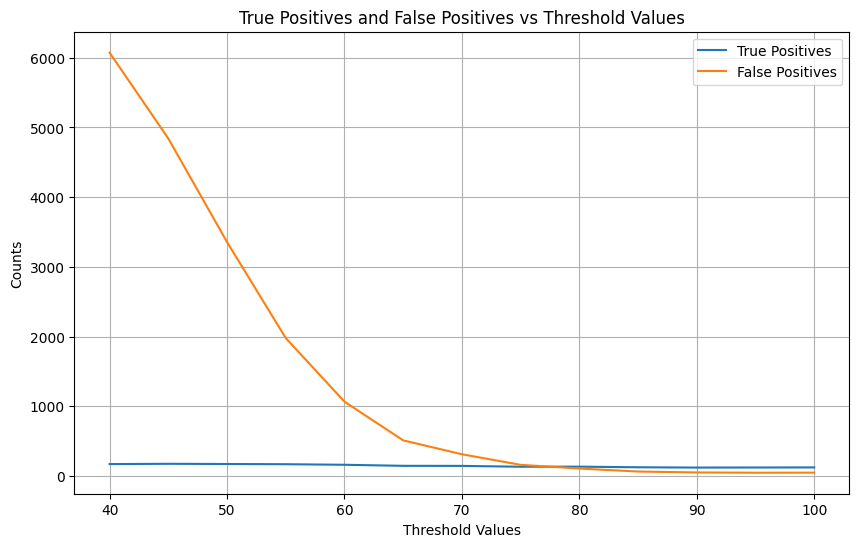

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df contains your data
data = {
    'fuzzy_threshold': [40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0],
    'true_positives': [172.0, 176.0, 173.0, 170.0, 162.0, 147.0, 146.0, 134.0, 135.0, 126.0, 122.0, 123.0, 124.0],
    'false_positives': [6072.0, 4841.0, 3356.0, 1979.0, 1067.0, 512.0, 313.0, 161.0, 108.0, 65.0, 52.0, 48.0, 49.0],
    'Recall': [0.851485, 0.871287, 0.856436, 0.841584, 0.801980, 0.727723, 0.722772, 0.663366, 0.668317, 0.623762, 0.603960, 0.608911, 0.613861],
    "F1-Score" : [0.053366, 0.067446, 0.092737, 0.144619, 0.226415, 0.341463, 0.441755, 0.539235, 0.606742, 0.641221, 0.648936, 0.659517, 0.661333]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['fuzzy_threshold'], df['F1-Score'], label='True Positives')
plt.plot(df['fuzzy_threshold'], df['Recall'], label='False Positives')

plt.xlabel('Threshold Values')
plt.ylabel('Counts')
plt.title('True Positives and False Positives vs Threshold Values')
plt.legend()
plt.grid(True)

plt.show()


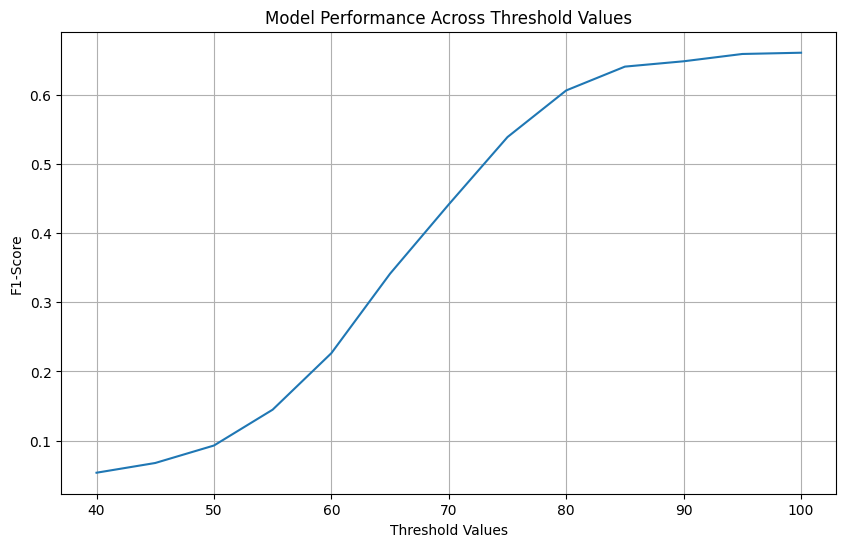

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df contains your data
data = {
    'fuzzy_threshold': [40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0],
    'true_positives': [172.0, 176.0, 173.0, 170.0, 162.0, 147.0, 146.0, 134.0, 135.0, 126.0, 122.0, 123.0, 124.0],
    'false_positives': [6072.0, 4841.0, 3356.0, 1979.0, 1067.0, 512.0, 313.0, 161.0, 108.0, 65.0, 52.0, 48.0, 49.0],
    'Recall': [0.851485, 0.871287, 0.856436, 0.841584, 0.801980, 0.727723, 0.722772, 0.663366, 0.668317, 0.623762, 0.603960, 0.608911, 0.613861],
    "F1-Score" : [0.053366, 0.067446, 0.092737, 0.144619, 0.226415, 0.341463, 0.441755, 0.539235, 0.606742, 0.641221, 0.648936, 0.659517, 0.661333]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['fuzzy_threshold'], df['F1-Score'], label='True Positives')
#plt.plot(df['fuzzy_threshold'], df['Recall'], label='False Positives')

plt.xlabel('Threshold Values')
plt.ylabel('F1-Score')
plt.title('Model Performance Across Threshold Values')
#plt.legend()
plt.grid(True)

plt.show()
